In [1]:
from __future__ import print_function
from net.models import AAMS_test as AAMS

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import argparse
import os
from tqdm import tqdm
import time

from net.network import AttentionNet, Encoder, Decoder, SelfAttention
from net.utils import adaptive_instance_normalization
%load_ext autoreload
%autoreload 2


In [2]:
parser = argparse.ArgumentParser()
# Basic options
parser.add_argument('--content_image', type=str, default='./datasets/test/content/lenna_wct_lost.png',
                    help='Directory path to a batch of content images')
parser.add_argument('--style_image', type=str, default='./datasets/test/style/candy.jpg',
                    help='Directory path to a batch of style images')

parser.add_argument('--attn_model', type=str, default='models/content_wct/',
                    help='Directory path to a batch of style images')
parser.add_argument('--decoder_model', type=str, default='models/content_wct/',
                    help='Directory path to a batch of style images')
# parser.add_argument('--save_dir', type=str, default='test_results/',
#                     help='Directory path to a batch of style images')
args = parser.parse_args('')

content_name = args.content_image.split('/')[-1].split('.')[0]
style_name = args.style_image.split('/')[-1].split('.')[0]
attn_model_dir = args.attn_model.split('/')[-2]
decoder_model_dir = args.decoder_model.split('/')[-2]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

cuda


torch.Size([3, 400, 400])
torch.Size([3, 512, 512])


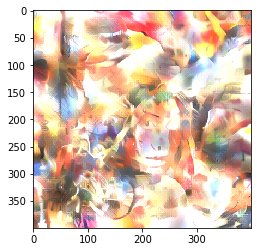

In [4]:
# loading test data

def test_transform(size = 512):
    transform = transforms.Compose([
        transforms.Resize(size=(size, size)),
        # transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ])
    return transform

def test_transform_inv():
    transform = transforms.Compose([
        transforms.Normalize((0, 0, 0), (2, 2, 2)),
        transforms.Normalize((-_R_MEAN/255.0, -_G_MEAN/255.0, -_B_MEAN/255.0), (1, 1, 1))
    ])
    return transform

content_tf = test_transform(400)
style_tf = test_transform()
content_tf_inv = test_transform_inv()
content = content_tf(Image.open(args.content_image).convert('RGB'))
print(content.shape)

style = style_tf(Image.open(args.style_image).convert('RGB'))
print(style.shape)

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(content_tf_inv(content)))

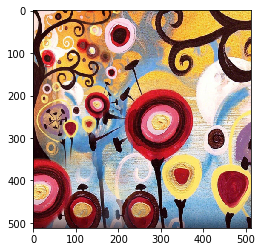

In [5]:
imshow(torchvision.utils.make_grid(content_tf_inv(style)))

In [6]:
decoder = Decoder()
decoder.load_state_dict(torch.load(args.decoder_model + 'decoder_iter_80000.pth'))
attn = SelfAttention()
attn.load_state_dict(torch.load(args.attn_model + 'attention_kernel_iter_80000.pth'))
    
state_dict = decoder.state_dict()
for key in state_dict.keys():
    state_dict[key] = state_dict[key].to(device)
state_dict = attn.state_dict()
for key in state_dict.keys():
    state_dict[key] = state_dict[key].to(device)
    
model = AttentionNet(seperate=False, attn=attn, decoder=decoder)
model.cuda()

AttentionNet(
  (encode): Encoder()
  (self_attn): SelfAttention(
    (f): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (g): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (h): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (decode): Decoder(
    (deconv_4): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode=nearest)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (6): ReLU()
      (7): ReflectionPad2d((1, 1, 1, 1))
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (9): ReLU()
      (10): ReflectionPad2d((1, 1, 1, 1))
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (12): ReLU()
    )
    (deconv_3): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(256, 128, kernel_size=(3, 3), s

In [7]:
content = torch.stack([content], dim = 0)
content = content.to(device)
style = torch.stack([style], dim = 0)
style = style.to(device)

In [8]:
aams = AAMS(model)

In [9]:
output, content_attn_map, style_attn_map, centroids, outputs, projected_content_features = aams.transfer(content, style)

## Show and Save Results

In [10]:
def imshow_recon(img, save_dir):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.savefig(save_dir)
    torchvision.utils.save_image(img, save_dir)
    
def show_output(output, save_dir):
    print("Saving to " + save_dir)
    content_result = content_tf_inv(output.squeeze())
    imshow_recon(torchvision.utils.make_grid(content_result.cpu()), save_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving to test_result/multistroke/lenna_wct_lost_with_candy_stroke0_content_wct_content_wct.png


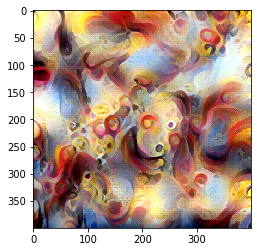

In [11]:
show_output(outputs[0], 'test_result/multistroke/' + content_name + '_with_' + style_name + '_stroke0_' + attn_model_dir + '_' + decoder_model_dir + '.png')

Saving to test_result/multistroke/lenna_wct_lost_with_candy_stroke1_content_wct_content_wct.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


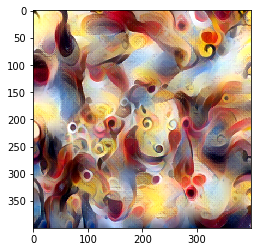

In [12]:
show_output(outputs[1], 'test_result/multistroke/' + content_name + '_with_' + style_name + '_stroke1_' + attn_model_dir + '_' + decoder_model_dir + '.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving to test_result/multistroke/lenna_wct_lost_with_candy_stroke2_content_wct_content_wct.png


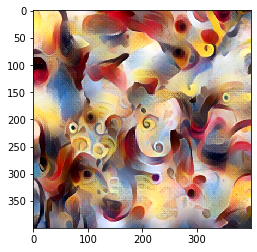

In [13]:
show_output(outputs[2], 'test_result/multistroke/' + content_name + '_with_' + style_name + '_stroke2_' + attn_model_dir + '_' + decoder_model_dir + '.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving to test_result/multistroke/lenna_wct_lost_with_candy_stroke3_content_wct_content_wct.png


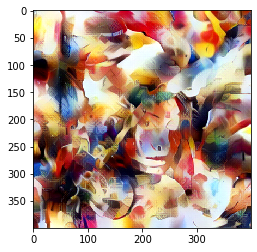

In [14]:
outputs[3] = adaptive_instance_normalization(outputs[3], style)
show_output(outputs[3], 'test_result/multistroke/' + content_name + '_with_' + style_name + '_stroke3_' + attn_model_dir + '_' + decoder_model_dir + '.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving to test_result/output/lenna_wct_lost_with_candy_content_wct_content_wct.png


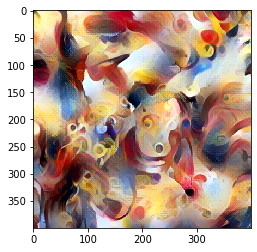

In [15]:
show_output(output, 'test_result/output/' + content_name + '_with_' + style_name + '_' + attn_model_dir + '_' + decoder_model_dir + '.png')

Saving to datasets/test/content/lenna_wct_lost.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


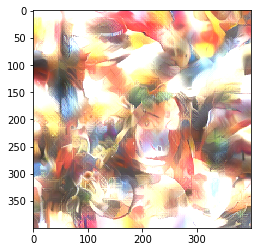

In [16]:
show_output(projected_content_features, 'datasets/test/content/lenna_wct_lost.png')

In [17]:
def save_attn_map(attn_map, save_dir):
    channel_num = attn_map.size()[1]
    mean_sal = torch.mean(attn_map, 1, False)
    mean_sal_np = mean_sal.cpu().detach().numpy()
    mean_sal_np = mean_sal_np - np.min(mean_sal_np)
    mean_sal_np = mean_sal_np * 1.0 / np.max(mean_sal_np)
    # print(mean_sal.size())
    plt.imshow(mean_sal_np[0], cmap=cm.get_cmap('rainbow', 1000))
    plt.colorbar()
    plt.axis('off')
    plt.savefig(save_dir)

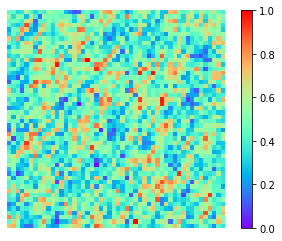

In [18]:
save_attn_map(content_attn_map, 'test_result/attention/' + content_name + '_AdaIN' + '.png')

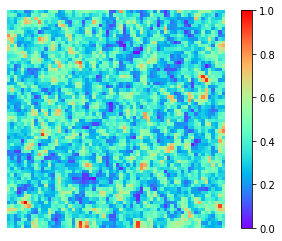

In [19]:
save_attn_map(style_attn_map, 'test_result/attention/' + style_name + '_AdaIN' + '.png')